# 利用 Product Formula 模拟时间演化
<em> Copyright (c) 2021 Institute for Quantum Computing, Baidu Inc. All Rights Reserved. </em>

## 概述

量子力学中系统的能量由哈密顿量算符 $H$ 描述，求解给定系统的哈密顿量的全部或者部分性质，构成了凝聚态物理、计算化学和高能物理等一系列学科的核心问题。然而，由于系统的自由度随系统增大呈指数级增加，导致一般情况下无法利用经典计算机有效模拟量子系统——即便用光全世界的内存和硬盘也不能直接储存一个仅几百量子比特的系统的态矢量。与经典计算机不同，量子计算机由于其所有的操作都是直接作用在同样为指数级别的态空间上，因而在模拟一个量子系统上量子计算机具有经典计算机无法比拟的优势。实际上，设计一个可控的量子系统来高效模拟自然界中的量子系统，正是费曼在上世纪 80 年代提出量子计算这一概念时的最初想法：
 
> _"Nature isn't classical, dammit, and if you want to make a simulation of nature, you'd better make it quantum mechanical, and by golly it's a wonderful problem, because it doesn't look so easy."_
>
> --- "Simulating physics with computers", 1982, Richard P. Feynman [1]

通用量子计算机以及一系列量子模拟器的发展令费曼的设想有了实现的可能。在通用量子计算机上进行数字量子模拟（digital quantum simulation）—— 利用量子门构造量子线路从而实现量子模拟，由于该方法具有较高的可拓展性和通用性，因而被认为是最有潜力的技术路线。

本教程讲述了如何利用 Paddle Quantum 模拟量子系统的时间演化过程，主要分为以下三个部分：
1. 如何在 Paddle Quantum 中创建并操作一个 `Hamiltonian` 对象
2. 如何利用 `construct_trotter_circuit` 来构建时间演化电路
3. Suzuki product formula 方法的原理，以及如何进一步搭建任意阶的 Trotter-Suzuki 电路


## 定义系统哈密顿量

在介绍如何搭建时间演化电路之前，读者可以先熟悉一下 Paddle Quantum 中的哈密顿量。目前用户需要通过定义一个列表的形式来创建哈密顿量，列表中的元素应为哈密顿量中的每一项的系数与其泡利算符。作为教程，我们首先考虑一个简单的哈密顿量：

$$
H = Z \otimes Z
\tag{1}
$$

该哈密顿量描述了两个量子比特之间的一种简单相互作用：当两个量子比特同时处于 $|0\rangle$ 态或者 $|1\rangle$ 态时，系统的能量为 $+1$；相反，当两个量子比特的态不同时，系统的能量为 $-1$。

接下来，用户可以在 Paddle Quantum 中创建这一哈密顿量：

In [1]:
from paddle_quantum.utils import Hamiltonian

h = Hamiltonian([[1, 'Z0, Z1']])
print(h)

1.0 Z0, Z1


目前，Paddle Quantum 中的哈密顿量类 `Hamiltonian` 支持自动合并同类项，加减法、索引以及拆分等操作：

In [2]:
h = Hamiltonian([[0.5, 'Z0, Z1'], [0.5, 'Z1, Z0']], compress=True)
print(h)

1.0 Z0, Z1


In [3]:
print('h + h:', h + h)
print('h * 2:', h * 2)
print('h:', h[:])

h + h: 2.0 Z0, Z1
h * 2: 2.0 Z0, Z1
h: 1.0 Z0, Z1


同时，内置的 `decompose_pauli_words()` 和 `decompose_with_sites()` 方法可以将哈密顿量分解为更加方便处理的形式：

In [4]:
print('Pauli words 分解：', h.decompose_pauli_words())
print('Pauli with sites 分解：', h.decompose_with_sites())

Pauli words 分解： ([1.0], ['ZZ'])
Pauli with sites 分解： ([1.0], ['ZZ'], [[0, 1]])


除此之外，`construct_h_matrix()` 还可以创建其在泡利 $Z$ 基底下的矩阵形式：

In [5]:
h.construct_h_matrix()

matrix([[ 1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
        [ 0.+0.j, -1.+0.j,  0.+0.j,  0.+0.j],
        [ 0.+0.j,  0.+0.j, -1.+0.j,  0.+0.j],
        [ 0.+0.j,  0.+0.j,  0.+0.j,  1.+0.j]])

## 模拟时间演化

根据量子力学的基本公理，在确定了一个系统的哈密顿量之后，该系统随时间演化的过程可以由如下方程描述

$$
i \hbar \frac{\partial}{\partial t} | \psi \rangle = H | \psi \rangle,
\tag{2}
$$

$\hbar$ 为约化普朗克常数。该方程正是著名的薛定谔方程。因此，对于一个不含时的哈密顿量，系统的时间演化方程可以写为

$$
|\psi(t) \rangle = U(t) | \psi (0) \rangle, ~ U(t) = e^{- i H t}.
\tag{3}
$$

这里我们取自然单位 $\hbar=1$，$U(t)$ 为时间演化算符。利用量子线路来模拟时间演化过程的核心思想是利用量子电路构建出的酉变换模拟和近似该时间演化算符。在量桨中，我们提供了 `construct_trotter_circuit(circuit, Hamiltonian)` 函数来构建对应某一个哈密顿量的时间演化电路。下面，就让我们用刚刚创建的哈密顿量来测试一下：

In [6]:
from paddle_quantum.trotter import construct_trotter_circuit
from paddle_quantum.circuit import UAnsatz

cir = UAnsatz(2)
construct_trotter_circuit(cir, h, tau=1, steps=1) 
print(cir)

--*-----------------*--
  |                 |  
--x----Rz(2.000)----x--
                       


可以看到，我们已经创建了针对 `h` 的基本量子模拟电路，它可以根据输入的 `tau` 来模拟任意时间长度的时间演化。

此时，如果检查该电路对应的酉变换的矩阵形式，会发现它与时间演化算符 $e^{-iHt}$ 完全一致。这里，我们先使用 `gate_fidelity` 来计算量子电路的酉矩阵和时间演化算符的酉矩阵之间的保真度。保真度越接近 1 时代表两个酉矩阵代表的演化过程越相似。在下文，我们还会引入更加严格的误差定义。

In [7]:
from scipy import linalg
from paddle_quantum.utils import gate_fidelity

# 计算 e^{-iHt} 和电路的酉矩阵之间的保真度
print('电路的酉算符和时间演化算符之间的保真度为： %.3f' 
      % gate_fidelity(cir.U.numpy(), linalg.expm(-1 * 1j * h.construct_h_matrix())))

电路的酉算符和时间演化算符之间的保真度为： 1.000


实际上，这是因为泡利算符组成的张量积对应的任意角度旋转算符都可以被很好的分解为门电路的形式。比如在这个例子中我们只需要改变电路中 Rz 门的角度，就可以实现任意 $e^{-i Z\otimes Z t}$ 演化算符的模拟。那么，这是否意味着可以用类似的电路形式来对任意的写成泡利形式的哈密顿量进行完美的模拟呢？答案是否定的。考虑一个稍微复杂一些的哈密顿量：

$$
H = Z \otimes Z + X \otimes I + I \otimes X.
\tag{4}
$$

同样地，让我们用 `construct_trotter_circuit` 来构建它所对应的时间演化电路：

In [8]:
h_2 = Hamiltonian([[1, 'Z0, Z1'], [1, 'X0'], [1, 'X1']]) # 不需要写出单位算符
cir = UAnsatz(2)
construct_trotter_circuit(cir, h_2, tau=1, steps=1)
print(cir)
print('电路的酉算符和时间演化算符之间的保真度为： %.3f' 
      % gate_fidelity(cir.U.numpy(), linalg.expm(-1 * 1j * h_2.construct_h_matrix())))

--*-----------------*----Rx(2.000)--
  |                 |               
--x----Rz(2.000)----x----Rx(2.000)--
                                    
电路的酉算符和时间演化算符之间的保真度为： 0.681


可以看到，此时电路对应的酉矩阵和时间演化矩阵之间的保真度 $<1$，说明该电路无法正确地模拟系统的时间演化过程。

其实，对于我们此时构建的电路而言，它对应的酉变换为 $e^{-iZ\otimes Z t} e^{-i (X\otimes I + I\otimes X)t}$，而时间演化算符为 $e^{-iZ\otimes Z t - i(X\otimes I + I\otimes X)t}$。而对于一个量子系统而言，当两个算符不对易，即 $[A, B] \neq 0$ 时，$e^{A+B} \neq e^A e^B$。在这里，因为泡利算符 $X$ 和 $Z$ 之间并不对易，所以电路对应的酉变换并不等于正确的时间演化算符。

除了利用保真度来描述量子电路和希望模拟的时间演化算符之间的相似性之外，我们还可以定义如下的误差 $\epsilon$ 来刻画模拟演化电路和演化算符之间的距离，

$$
\epsilon(U) = \Vert e^{-iHt} - U \Vert,
\tag{5}
$$

其中 $\Vert \cdot \Vert$ 表示取最大的本征（奇异）值的模。这样的定义比起保真度而言更好的描述了量子态在不同的演化算符作用下产生的偏差，是一种更加严谨的定义模拟时间演化误差的方式。我们在下文中也会多次用到该误差。

### Product formula 与 Suzuki 分解

Seth Lloyd 在 1996 年的文章中指出，可以将一整段的演化时间 $t$ 拆分为 $r$ 份较短的“时间块”来减小模拟时间演化的误差 [2]。考虑一个更一般的哈密顿量形式 $H = \sum_{k=1}^{L} h_k$，其中 $h_k$ 是作用在一部分系统上的子哈密顿量。通过泰勒展开，不难发现其模拟误差是一个二阶项，即

$$
e^{-iHt} = \prod_{k=1}^{L} e^{-i h_k t} + O(t^2).
\tag{6}
$$

那么，我们令 $\tau = t/r$，并考虑演化算符 $\left(e^{-iH \tau}\right)^r$，其演化误差为

$$
e^{-iHt} = \left(e^{-iH \tau}\right)^r = \left(\prod_{k=1}^{L} e^{-i h_k \tau} + O(\tau^2) \right)^r = \left(\prod_{k=1}^{L} e^{-i h_k \tau} \right)^r + O\left(\frac{t^2}{r}\right).
\tag{7}
$$

上式告诉我们，只要将一整段演化时间拆为足够多的“片段”，就可以达到任意高的模拟精度，这就是 product formula 的基本思想。不过，(7) 中给出的误差只是一个粗略的估计。在实际情况中，为了估计达到某一模拟精度所需要的量子电路深度，就需要进一步推导其更严格的误差上界。下面，我们展示一个比较简略的误差上界计算过程，对具体的计算过程不感兴趣的读者可以直接跳至 (11) 阅读这部分的结论。

记函数 $f$ 泰勒展开至 $k$ 阶之后的余项为 $\mathcal{R}_k(f)$, 我们需要用到如下两个结论：

$$
\left\Vert \mathcal{R}_k \left( \prod_{k=1}^{L} \exp (-i h_k \tau) \right) \right\Vert
\leq
\mathcal{R}_k \left( \exp \left( \sum_{k=1}^{L} \vert \tau \vert \cdot \Vert h_k \Vert \right) \right),
\tag{8}
$$

$$
\vert \mathcal{R}_k(\exp (\alpha)) \vert \leq \frac{\vert \alpha \vert^{k+1}}{(k+1)!} \exp ( \vert \alpha \vert ), ~
\forall \alpha \in \mathbb{C}.
\tag{9}
$$

这两个结论的证明略微有一些繁琐，故在此略去，感兴趣的读者可以参考 [3] 中的 F.1 节。利用 (5) 中的定义，模拟误差可以写为

$$
\epsilon\left(e^{-iH\tau}, U_{\rm circuit}\right) = \left \Vert \exp\left(-i\sum_{k=1}^L h_k \tau\right) - \prod_{k=1}^{L} \exp\left(-i h_k \tau \right) \right \Vert.
\tag{10}
$$

我们已经知道，此时的误差是泰勒展开至一阶后的余项，再利用 (8)，(9) 和三角不等式，可以将 (10) 中的误差上界进行计算：

$$
\begin{aligned}
\left \Vert \exp\left(-i\sum_{k=1}^L h_k \tau\right) - \prod_{k=1}^{L} \exp\left(-i h_k \tau \right) \right \Vert
=~&
\left \Vert \mathcal{R}_1 \left( \exp \left( -i \sum_{k=1}^{L} h_k \tau \right) - \prod_{k=1}^{L} \exp (-i h_k \tau) \right) \right \Vert
\\
\leq~&
\left \Vert \mathcal{R}_1 \left( \exp \left( -i \sum_{k=1}^{L} h_k \tau \right) \right) \right \Vert
+
\left \Vert \mathcal{R}_1 \left( \prod_{k=1}^{L} \exp (-i h_k \tau) \right) \right \Vert
\\
\leq~ &
\left \Vert \mathcal{R}_1 \left( \exp \left( \vert \tau \vert \cdot \left \Vert \sum_{k=1}^{L} h_k \right \Vert \right) \right) \right \Vert
+ 
\left \Vert \mathcal{R}_1 \left( \exp \sum_{k=1}^{L} \left( \vert \tau \vert \cdot \Vert h_k \Vert \right) \right) \right \Vert
\\
\leq~&
2 \mathcal{R}_1 \left( \exp ( \vert \tau \vert L \Lambda ) \right )
\\
\leq~&
 ( \vert \tau \vert L \Lambda )^2 \exp ( \vert \tau \vert L \Lambda ),
\end{aligned}
\tag{11}
$$

其中 $\Lambda = \max_k \Vert h_k \Vert$。随后考虑完整的演化时间 $t = r \cdot \tau$，那么模拟长度为 $t$ 的时间演化算符时的误差为：

$$
\begin{aligned}
\left \Vert \left ( \exp\left(-i\sum_{k=1}^L h_k \tau \right)\right)^r - \left (\prod_{k=1}^{L} \exp\left(-i h_k \tau \right) \right)^r \right \Vert
\leq ~&
r \left \Vert \exp\left(-i\sum_{k=1}^L h_k \tau\right) - \prod_{k=1}^{L} \exp\left(-i h_k \tau \right) \right \Vert
\\
=~& r (  \tau L \Lambda )^2 \exp ( \vert \tau \vert L \Lambda )
\\
=~& \frac{(  t L \Lambda )^2}{r} \exp \left( \frac{\vert t \vert L \Lambda}{r} \right).
\end{aligned}
\tag{12}
$$

这里用到了量子电路中误差线性累积的结论，即 $\Vert U^r - V^r \Vert \leq r\Vert U - V \Vert$，不熟悉这一结论的读者可以参考 [4] 中的 4.5.3 节。至此，我们就计算出了 product formula 对于一段完整的演化时间 $t$ 的模拟误差上界，即 (7) 式中的二阶项 $O(t^2/r)$。 

实际上，我们还可以通过 Suzuki 分解的方法来进一步优化对每一个“时间块”内的时间演化算符 $e^{-iH\tau}$ 的模拟精度。对于哈密顿量 $H = \sum_{k=1}^{L} a_k h_k$，其时间演化算符的 Suzuki 分解可以写为

$$
\begin{aligned}
S_1(\tau) &= \prod_{k=0}^L \exp ( -i h_k \tau)，
\\
S_2(\tau) &= \prod_{k=0}^L \exp ( -i h_k \frac{\tau}{2})\prod_{k=L}^0 \exp ( -i h_k \frac{\tau}{2})，
\\
S_{2k}(\tau) &= [S_{2k - 2}(p_k\tau)]^2S_{2k - 2}\left( (1-4p_k)\tau\right)[S_{2k - 2}(p_k\tau)]^2,
\end{aligned}
\tag{13}
$$

对于 $k > 1, k\in\mathbb{Z}$，其中 $p_k = 1/(4 - 4^{1/(2k - 1)})$。先前推导的 product formula 实际上只使用了一阶的 Suzuki 分解 $S_1(\tau)$ 来对每个“时间块”进行模拟，因此也被称为一阶 Suzuki product formula，或者简称一阶 product formula。Suzuki product formula 在物理中也经常被称为 Trotter-Suzuki 分解方法。对于更高阶的 product formula 而言，使用 (10-12) 中类似的计算，可以证明第 $2k$ 阶 product formula 的整体误差上界为：

$$
\epsilon\left(e^{-iHt}, \left(S_{2k}(\tau)\right)^r\right)
\leq
\frac{(2L5^{k-1}\Lambda\vert t \vert)^{2k+1}}{3r^{2k}} \exp \left( \frac{2L5^{k-1}\Lambda\vert t \vert}{r} \right),
~ k > 1.
\tag{14}
$$

在得到了模拟误差上界的基础上，还可以进一步计算达到一定最小精度 $\epsilon$ 时所需要的电路深度的下界。需要指出的是，(12) 和 (14) 中给出的误差上界的计算是十分宽松的。近年来，许多工作都进一步地给出了更加紧致的上界 [3, 5-6]。此外，也有人提出了不基于 Suzuki 分解的 product formula [7]。

![image.png](./figures/trotter_suzuki_circuit.png)
<div style="text-align:center">图1：Suzuki product formula 电路的示意图</div>

### 利用 Paddle Quantum 验证基于 Suzuki-product formula 的时间演化电路

尽管人们不断的在优化 Suzuki-product formula 的误差上界，但是在实际使用中，真实的误差往往和理论上给出的上界有一定差距，也就是说，我们现在能计算的理论上的 product formula 误差依然只是一个十分宽松的上界 [3]。因此，对于一个真实的物理系统，我们往往需要通过数值实验来计算其真实的误差，从而给出一个经验性的误差上界（empirical bound）。这样的数值试验对于计算在一定精度下模拟某一时间演化过程所需要的电路深度十分重要。

在刚刚介绍的 `construct_trotter_circuit` 函数中，用户也可以通过改变传入参数 `tau`、`steps`、`order` 来实现对任意阶 Suzuki product formula 电路的创建。下面，我们就利用该函数的这一功能来验证一下 Suzuki product formula 的误差。

继续使用先前的哈密顿量：

In [9]:
print('H =', h_2)

H = 1.0 Z0, Z1
1.0 X0
1.0 X1


这里我们通过改变 `tau` 和 `steps` 两个参数来将 $t=1$ 的演化过程进行拆分。（提示：$\tau \cdot n_{\rm steps} = t$）

In [10]:
# 将长度为 t 的时间演化过程拆为 r 份
r = 3
t = 1
cir = UAnsatz(2)
# 搭建时间演化电路，tau 为每个“时间块”的演化时间，故为 t/r，steps 是“时间块”的重复次数 r
construct_trotter_circuit(cir, h_2, tau=t/r, steps=r)
print(cir)
print('电路的酉算符和时间演化算符之间的保真度为： %.3f' 
      % gate_fidelity(cir.U.numpy(), linalg.expm(-1 * 1j * h_2.construct_h_matrix())))

--*-----------------*----Rx(0.667)----*-----------------*----Rx(0.667)----*-----------------*----Rx(0.667)--
  |                 |                 |                 |                 |                 |               
--x----Rz(0.667)----x----Rx(0.667)----x----Rz(0.667)----x----Rx(0.667)----x----Rz(0.667)----x----Rx(0.667)--
                                                                                                            
电路的酉算符和时间演化算符之间的保真度为： 0.984


我们发现，通过将 $t=1$ 的模拟时间拆分为三个“时间块”，模拟误差被成功减小了。

如果进一步地增加拆分后的“时间块”的数量的话，误差还可以被进一步减小：

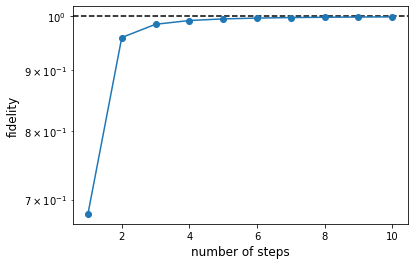

In [11]:
# 导入一些作图和计算误差需要的额外包
import matplotlib.pyplot as plt
import numpy as np

def get_fid(n_steps):
    t = 1
    cir = UAnsatz(2)
    construct_trotter_circuit(cir, h_2, tau=t/n_steps, steps=n_steps)
    return gate_fidelity(cir.U.numpy(), linalg.expm(-1 * 1j * h_2.construct_h_matrix()))
plt.axhline(1, ls='--', color='black')
plt.semilogy(np.arange(1, 11), [get_fid(r) for r in np.arange(1, 11)], 'o-')
plt.xlabel('number of steps', fontsize=12)
plt.ylabel('fidelity', fontsize=12)
plt.show()

不仅如此，我们还可以通过改变 product formula 的阶数来减小模拟误差。目前，`construct_trotter_circuit()` 函数支持通过参数 `order` 来实现任意阶数的 Suzuki product formula。下面，就让我们来分别计算一下一阶和二阶时间演化电路的误差随着 $\tau$ 大小的变化，并和上文中计算的理论误差上界进行对比：

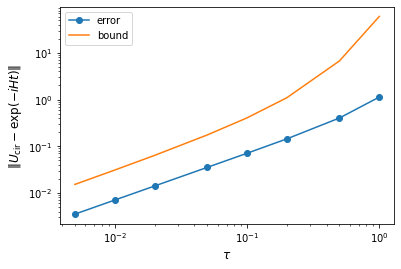

In [12]:
# 计算两个酉矩阵之间的 L1 谱距离，即 (5) 中定义的误差
def calculate_error(U1, U2):
    return np.abs(linalg.eig(U1 - U2)[0]).max()

# 封装计算误差的函数，自由参数为每个时间块的长度 tau 和 product formula 的阶数 order
def calculate_total_error(tau, order=1):
    # 注意因为在电路中的多 Pauli 旋转门时会引入一个额外的全局相位，需要在计算误差时扣除
    # 补充：该全局相位不会对实际的量子态产生任何可观测的影响，只是计算理论误差时需要扣除
    h_2 = Hamiltonian([[1, 'Z0, Z1'], [1, 'X0'], [1, 'X1']])
    cir = UAnsatz(2)
    # 应为总时长为 1，故 steps = int(1/tau)，注意传入的 tau 需要可以整除 1
    construct_trotter_circuit(cir, h_2, tau=tau, steps=int(1/tau), order=order)
    cir_U = cir.U.numpy()
    U_evolve =  np.exp(1j) * linalg.expm(-1 * 1j * h_2.construct_h_matrix()) #理论上的时间演化算符加上一个全局相位
    return calculate_error(cir_U, U_evolve)

# 不同的参数 tau，注意它们需要可以整除 1
taus = np.array([0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1])
errors = []

# 记录对应不同 tau 的总误差
for tau in taus:
    errors.append(calculate_total_error(tau))    

# 可视化结果
plt.loglog(taus, errors, 'o-', label='error')
plt.loglog(taus, (3 * taus**2 * (1/taus) * np.exp(3 * taus)), label='bound') # 按照 (10) 计算的一阶误差上界
plt.legend()
plt.xlabel(r'$\tau$', fontsize=12)
plt.ylabel(r'$\Vert U_{\rm cir} - \exp(-iHt) \Vert$', fontsize=12)
plt.show()

下面，我们将 `order` 设置为 2，并计算二阶 product formula 的误差：

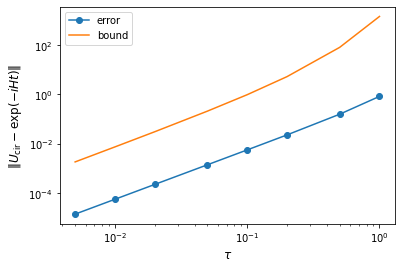

In [13]:
taus = np.array([0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1])
errors = []

for tau in taus:
    errors.append(calculate_total_error(tau, order=2)) # 通过 order=2 指定 Suzuki 分解的阶数    

plt.loglog(taus, errors, 'o-', label='error')
plt.loglog(taus, (2 * taus * 3 )**3 / 3 * (1/taus) * np.exp(3 * taus), '-', label='bound') # 按照 (12) 计算的二阶误差上界
plt.legend()
plt.xlabel(r'$\tau$', fontsize=12)
plt.ylabel(r'$\Vert U_{\rm cir} - \exp(-iHt) \Vert$', fontsize=12)
plt.show()

可以看到，实际计算出的模拟误差都小于其理论上界，说明这样的结果是符合预期的。

## 小结

本教程介绍了 Paddle Quantum 中构建模拟时间演化电路的功能，并对其背后的理论基础——Suzuki product formula 进行了介绍。利用该功能，用户可以通过搭建对于自定义哈密顿量的任意阶 product formula 电路来模拟不同物理系统的时间演化过程。

量子模拟本身是一个比较宽泛的话题，其应用也十分广泛：凝聚态物理中的多体局域化、时间晶体、高温超导、拓扑序的研究；量子化学中的分子动力学模拟、反应模拟；高能物理中的场论模拟；乃至核物理和宇宙学中的相关研究。本教程中介绍的 Suzuki product formula 与基于通用量子计算机的数字量子模拟只是量子模拟的一部分，许多不基于通用量子计算机的量子模拟器，例如在冷原子、超导、离子阱以及光子等平台上做的模拟量子模拟（analogue quantum simulation）也是一个十分重要的方向。鉴于篇幅，本教程中无法进一步对这些内容逐一展开介绍，感兴趣的读者可以阅读 14 年的这篇综述文章 [8]。对于一些更新的结果，也可以参考这篇中文综述 [9]。

在后续的教程 [模拟一维海森堡链的自旋动力学](./SimulateHeisenberg_CN.ipynb) 中，我们以凝聚态物理中的自旋模型为例，进一步地展示了如何利用本文中介绍的内容来进行量子多体模型的动力学模拟。同时，该教程也将介绍如何搭建不基于 Suzuki 分解的自定义时间演化电路。

---

## 参考资料

[1] Feynman, R. P. "Simulating physics with computers." International Journal of Theoretical Physics 21.6 (1982).
 
[2] Lloyd, Seth. "Universal quantum simulators." [Science (1996): 1073-1078](https://www.jstor.org/stable/2899535).

[3] Childs, Andrew M., et al. "Toward the first quantum simulation with quantum speedup." [Proceedings of the National Academy of Sciences 115.38 (2018): 9456-9461](https://www.pnas.org/content/115/38/9456.short).

[4] Nielsen, Michael A., and Isaac Chuang. "Quantum computation and quantum information." (2002): 558-559.

[5] Tran, Minh C., et al. "Destructive error interference in product-formula lattice simulation." [Physical Review Letters 124.22 (2020): 220502](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.124.220502).

[6] Childs, Andrew M., and Yuan Su. "Nearly optimal lattice simulation by product formulas." [Physical Review Letters 123.5 (2019): 050503](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.123.050503).

[7] Campbell, Earl. "Random compiler for fast Hamiltonian simulation." [Physical Review Letters 123.7 (2019): 070503](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.123.070503).

[8] Georgescu, Iulia M., Sahel Ashhab, and Franco Nori. "Quantum simulation." [Reviews of Modern Physics 86.1 (2014): 153](https://journals.aps.org/rmp/abstract/10.1103/RevModPhys.86.153).

[9] 范桁. "量子计算与量子模拟." [物理学报 67.12(2018):16-25](http://wulixb.iphy.ac.cn/article/id/72211).